In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.debugger import set_trace
from IPython.display import display

# Import packages

In [1]:
import os
import sys
import pandas as pd
import numpy as np

import time
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.transforms as tfs
from matplotlib.pyplot import figure
from PIL import Image as PILImage
import PIL.ImageOps as ImageOps


ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if ros_path in sys.path:
    sys.path.remove(ros_path)
    
import cv2
from sklearn.preprocessing import MinMaxScaler

# Custom packages
user_dir = os.path.expanduser('~')
project_dir = os.path.join(user_dir, 'VirtualCore')
if project_dir not in sys.path:
    print('sys.append: {}'.format(project_dir))
    sys.path.append(project_dir)
    
import utils_dir.utils as utils
from utils_dir.utils import get_varargin, timeit
import utils_dir.logger_utils as logger_utils
import utils_dir.df_utils as df_utils  
logging = logger_utils.htmlLogger(log_file = '{}_virtualCore_logging.html'.format(datetime.now().strftime('%y%m%d')), 
                                 mode = 'w')
logging.info('Project Dir: {}'.format(project_dir))

ERROR:root:list index out of range


ModuleNotFoundError: No module named 'vlogging'

# Functions

In [3]:
def read_image_logs(filepath):
    column_names = ['DEPTH']
    image_headers_list = ["image_"+str(i) for i in range(0, 360)]
    column_names = column_names + image_headers_list
    df = pd.read_csv(filepath, sep='\s+',skipinitialspace=True,names=column_names)
    return df

def normalize_image_logs(df):
    df[df < 0] = 0
    scaler = MinMaxScaler(feature_range = (0,255))
    scaled_array = scaler.fit_transform(df.iloc[:,1:])
    scaled_df = pd.DataFrame(scaled_array)
    scaled_df['DEPTH'] = df['DEPTH']

    # Make column "DEPTH" first
    cols = list(scaled_df.columns)
    cols = [cols[-1]] + cols[:-1]
    scaled_df = scaled_df[cols]

    return scaled_df
#     return df

# Load Data

In [4]:
df_images = read_image_logs("Image_STAR_Static.txt")

In [97]:
df_images = normalize_image_logs(df_images)
start_image_log_ft = df_images.iloc[0,0]

org_img_list = []
for start_ft, end_ft in zip(range(1100, 1110, 1), range(1101,1111, 1)):
#     start_ft = 1111
#     end_ft = 1112
    # There are 120 rows in 1ft data
    start_point_pix = int((start_ft - start_image_log_ft) * 120)
    end_point_pix = int((end_ft - start_image_log_ft) * 120)
    df_int = df_images.iloc[start_point_pix:end_point_pix,:]
    org_img = df_int.iloc[:,1:].to_numpy(dtype = np.uint8)
    org_img_list.append(org_img)
# org_img = np.array(float_img * 255, dtype = np.uint8)
# fig = plt.figure(figsize = (20,10))
# plt.imshow(org_img, cmap = 'gray_r')
print(len(org_img_list))

10


In [140]:
def compute_axis_points(x1,y1,x2,y2,ylim):
    if x1 == x2:
        r = 1e6
    else:
        r = (y2-y1)/(x2 - x1)
        
    def find_y(x):
        y = r * (x-x1) + y1
        return y
    def find_x(y):
        x = (1/r)*(y-y1) + x1
        return x
    y1_out = 0
    x1_out = find_x(y1_out)
    y2_out = ylim
    x2_out = find_x(y2_out)
#     import pdb; pdb.set_trace()
    if x2_out < 0:
        x2_out = 0
        y2_out = find_y(x2_out)
    return int(x1_out), int(y1_out), int(x2_out), int(y2_out)

In [163]:
def clean_x(x_list):
    x_list.sort()
    x_new = [x_list[0]]
    for x in x_list[1:]:
        if (x-x_new[-1]) > 10:
            x_new.append(x)
    return x_new

In [207]:
def crop_img(I, polygon):
    # Define the polygon coordinates to use or the crop
#     polygon = [[[20,110],[450,108],[340,420],[125,420]]]

    # First find the minX minY maxX and maxY of the polygon
    minX = I.shape[1]
    maxX = -1
    minY = I.shape[0]
    maxY = -1
    for point in polygon:

        x = point[0]
        y = point[1]

        if x < minX:
            minX = x
        if x > maxX:
            maxX = x
        if y < minY:
            minY = y
        if y > maxY:
            maxY = y

    # Go over the points in the image if thay are out side of the emclosing rectangle put zero
    # if not check if thay are inside the polygon or not
    cropedImage = np.zeros_like(I)
    for y in range(0,I.shape[0]):
        for x in range(0, I.shape[1]):

            if x < minX or x > maxX or y < minY or y > maxY:
                continue

            if cv2.pointPolygonTest(np.asarray(polygon),(x,y),False) >= 0:
                cropedImage[y, x] = I[y, x]

    # Now we can crop again just the envloping rectangle
    finalImage = cropedImage[minY:maxY,minX:maxX]
    mask = np.zeros_like(finalImage)
    mask[finalImage == 0] = 1
    outputImage = cv2.inpaint(finalImage,mask,3,cv2.INPAINT_TELEA)
#     # Now strectch the polygon to a rectangle. We take the points that
#     polygonStrecth = np.float32([[0,0],[finalImage.shape[1],0],[finalImage.shape[1],finalImage.shape[0]],[0,finalImage.shape[0]]])

#     # Convert the polygon corrdanite to the new rectnagle
#     polygonForTransform = np.zeros_like(polygonStrecth)
#     i = 0
#     for point in polygon:

#         x = point[0]
#         y = point[1]

#         newX = x - minX
#         newY = y - minY

#         polygonForTransform[i] = [newX,newY]
#         i += 1


#     # Find affine transform
#     M = cv2.getPerspectiveTransform(np.asarray(polygonForTransform).astype(np.float32), np.asarray(polygonStrecth).astype(np.float32))

#     # Warp one image to the other
#     warpedImage = cv2.warpPerspective(finalImage, M, (finalImage.shape[1], finalImage.shape[0]))
    return outputImage

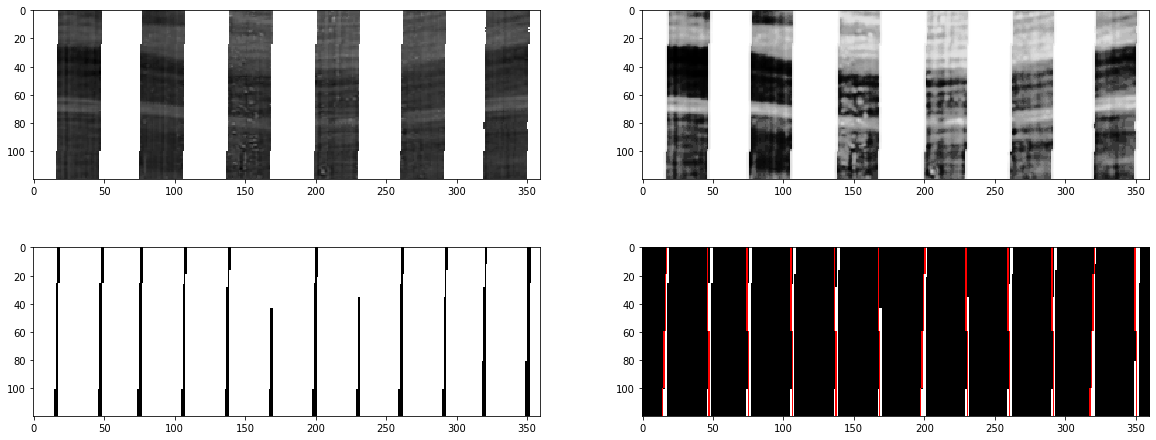

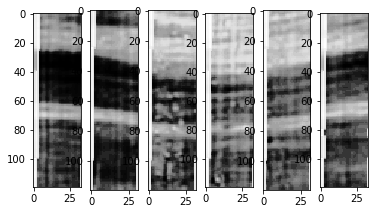

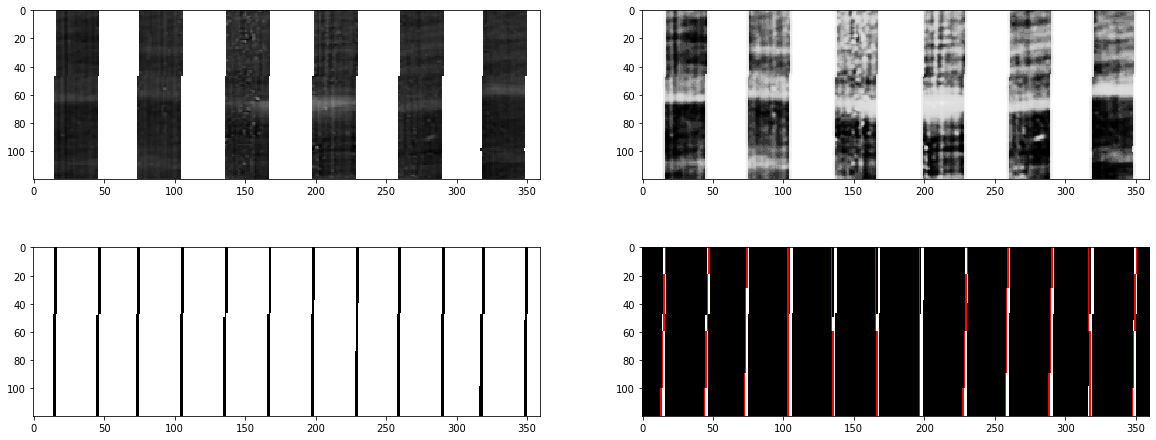

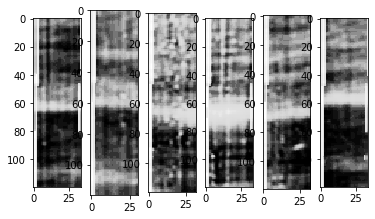

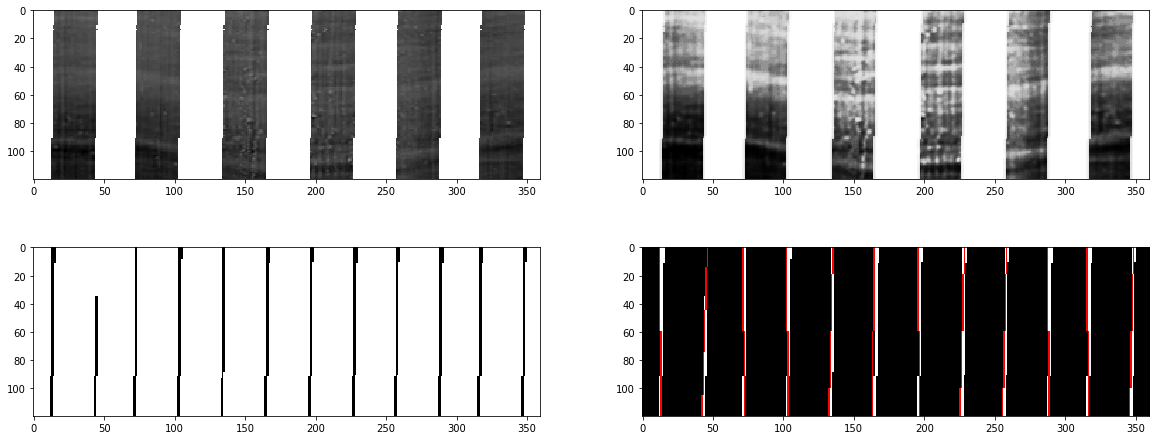

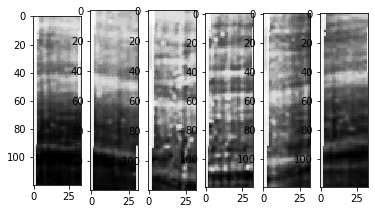

In [208]:
for org_img in org_img_list[3:6]:
    fig = plt.figure(figsize = (20, 8))
    # img = cv2.GaussianBlur(org_img, (5,5), 0)
    img = cv2.blur(org_img, (3,3), 0)
    # Increase contrast
    img1 = cv2.equalizeHist(org_img)
    img2 = cv2.equalizeHist(img)
    # Gaussian filter
    # Laplacian filter 
    img = cv2.Laplacian(org_img, cv2.CV_16S, ksize=1)
    img = cv2.convertScaleAbs(img)
    edges = cv2.medianBlur(img, 3, 0)
    # edges = cv2.Canny(edges,np.percentile(edges.flatten(), 90),150,apertureSize = 3)
    ret,edges = cv2.threshold(edges,np.percentile(edges.flatten(), 95),255,cv2.THRESH_BINARY)# Line detection
    kernel = np.ones((50,1), np.uint8)  # note this is a horizontal kernel
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.erode(edges, kernel, iterations=1) 
    # lines = cv2.HoughLines(edges,1,np.pi/180,20)
    # minLineLength = 100
    # maxLineGap = 10
    lines = cv2.HoughLinesP(edges,1,np.pi/180,threshold = 20,
                            minLineLength = 50 ,maxLineGap = 20)
    color_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    # print(lines.shape)
    ax = fig.add_subplot(221)
    plt.imshow(org_img, cmap = 'gray_r')
    ax = fig.add_subplot(222)
    plt.imshow(img2, cmap = 'gray_r')
    ax = fig.add_subplot(223)
    plt.imshow(edges, cmap = 'gray_r')
    x_low = []
    x_high = []
    if lines is not None:
        for line in lines:            
            x1,y1,x2,y2 = line[0]            
            ylim = 120
            x1,y1,x2,y2 = compute_axis_points(x1,y1,x2,y2,ylim)
#             print('x1, y1, x2, y2: ')            
            
            if y1==0:
                x_low.append(x1)
                x_high.append(x2)
            else:
                x_low.append(x2)
                x_high.append(x1)
#         fig = plt.figure(figsize = (10,10))
        x_low_new = clean_x(x_low)
        x_high_new = clean_x(x_high)
        for x1,x2 in zip(x_low_new, x_high_new):
            cv2.line(color_img,(x1,0),(x2,120),(255,0,0),1)
        ax = fig.add_subplot(224)
        plt.imshow(color_img, cmap = 'gray_r')
    
    fig = plt.figure()
    for idx in range(6):
        ax = fig.add_subplot(1,6,idx+1)
        cropped_img = crop_img(img2, [[x_low_new[2*idx], 0],[x_low_new[2*idx+1],0],
                                         [x_high_new[2*idx+1], 120],[x_high_new[2*idx], 120]])
        
        plt.imshow(cropped_img, cmap = 'gray_r')
    

In [157]:
x_low

In [162]:
x_low.sort()
print(x_low)
x_new = [x_low[0]]
for x in x_low[1:]:
    if (x-x_new[-1]) > 10:
        x_new.append(x)
x_new
    


[22, 22, 50, 51, 52, 78, 79, 80, 109, 110, 111, 140, 141, 142, 171, 172, 173, 203, 204, 234, 236, 263, 264, 265, 295, 296, 322, 323, 355]


[22, 50, 78, 109, 140, 171, 203, 234, 263, 295, 322, 355]

In [ ]:
utils.print_ndarray(edges)

In [ ]:
lines

In [ ]:
lines[0]

In [ ]:
from scipy.signal import butter, bessel, lfilter, sosfiltfilt, find_peaks, find_peaks_cwt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
avg = np.zeros((df_int.shape[0],))
for i in range(df_int.shape[0]):
    avg[i] = df_int.iloc[i,1:].mean()

# order = 6
# fs = 30.0       # sample rate, Hz
# cutoff = 5  # desired cutoff frequency of the filter, Hz
     
# filtered = butter_lowpass_filter(avg, cutoff, fs, order)  

# sos = butter(6, 0.02, btype='highpass', output='sos')
sos = butter(6, 0.125, btype='lowpass', output='sos')
filtered = sosfiltfilt(sos, avg)

deriv = np.gradient(filtered) #varargs = 0.0083333)
min_val = np.min(deriv)
max_val = np.max(deriv)
# print(min_val, max_val)
deriv_flip = max_val - deriv 

deriv_2 = np.gradient(deriv) #varargs = 0.0083333)

df_int['deriv_2'] = deriv_2

pks, _ = find_peaks(deriv, distance=20, prominence=(0.5,None))
pks_flip, _ = find_peaks(deriv_flip, distance=20, prominence=(0.5,None))

# print(df_int['DEPTH'], df_int['deriv_2'])

bound = df_int.loc[df_int['deriv_2'].abs()< 5e-4,['DEPTH','deriv_2']] 

# print(bound)


    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,120))
#     fig.suptitle("Well Composite", fontsize=22)
fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
for axes in ax:
#     axes.set_ylim(1168, 1099)
    axes.invert_yaxis()
#     axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False) 
#         for (i,j) in zip(tops_depths,tops):
#             if ((i>=top_depth) and (i<=bottom_depth)):
#                 axes.axhline(y=i, linewidth=0.5, color='black')
#                 axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        

    

# ax01=ax[0].twiny()
# #     ax01.set_xlim(-100,10)
# ax01.set_ylim(1168, 1099)
# ax01.spines['top'].set_position(('outward',0))
# ax01.plot(avg, df_int['DEPTH'], label='Orig', color='blue')
# ax01.set_xlabel('Orig',color='blue')    
# ax01.tick_params(axis='x', colors='blue')
# ax01.grid(True) 


ax01=ax[0].twiny()
# ax02.set_xlim(6,36)
ax01.set_ylim(1168, 1099)
ax01.plot(filtered, df_int['DEPTH'], '--', label='Filtered', color='red') 
ax01.spines['top'].set_position(('outward',0))
ax01.set_xlabel('Filtered',color='red')    
ax01.tick_params(axis='x', colors='red')
ax01.grid(True) 

# ax02=ax[0].twiny()
# # ax02.set_xlim(6,36)
# ax02.plot(filtered, df_int['DEPTH'], '--', label='Butter', color='red') 
# ax02.spines['top'].set_position(('outward',40))
# ax02.set_xlabel('Butter',color='red')    
# ax02.tick_params(axis='x', colors='red')

ax02=ax[0].twiny()
ax01.set_ylim(1168, 1099)
# ax02.set_xlim(6,36)
ax02.plot(deriv, df_int['DEPTH'], '--', label='Deriv', color='black') 
ax02.spines['top'].set_position(('outward',40))
ax02.set_xlabel('Deriv',color='black')    
ax02.tick_params(axis='x', colors='black')

# ax03=ax[0].twiny()
# ax01.set_ylim(1168, 1099)
# # ax02.set_xlim(6,36)
# ax03.plot(deriv_2, df_int['DEPTH'], '--', label='Second', color='green') 
# ax03.spines['top'].set_position(('outward',80))
# ax03.set_xlabel('SecondDeriv',color='green')    
# ax03.tick_params(axis='x', colors='green')

    
ax[1].imshow(df_int.iloc[:,1:], cmap = 'gray_r')

# for i in range(bound.shape[0]):
#     ax[1].axhline(y = bound.index[i] - bound.index[0])

for i in range(pks.shape[0]):
    ax[1].axhline(y = pks[i])
    
for i in range(pks_flip.shape[0]):
    ax[1].axhline(y = pks_flip[i])


#     ax01.set_xlim(-100,10)
# ax[1].spines['top'].set_position(('outward',0))
# ax[1].set_xlabel("Image")
# plt.xticks([])
# plt.yticks([])
# ax02.set_xlabel('Average',color='blue')    
# ax02.tick_params(axis='x', colors='blue')
# ax02.grid(True)  

plt.tight_layout() 
    

Image log splitted into 6 segments

In [ ]:
from scipy.interpolate import interp1d

sectors_num = 6
avg = np.zeros((sectors_num,df_int.shape[0]))
filtered = np.zeros((sectors_num,df_int.shape[0]))
deriv = np.zeros((sectors_num,df_int.shape[0]))
deriv_flip = np.zeros((sectors_num,df_int.shape[0]))
pks = np.zeros((sectors_num,df_int.shape[0]),dtype=int)
pks_y = np.zeros((sectors_num,df_int.shape[0]))
pks_x = np.zeros((sectors_num,df_int.shape[0]))
pks_flip = np.zeros((sectors_num,df_int.shape[0]),dtype=int)
pks_flip_y = np.zeros((sectors_num,df_int.shape[0]))
pks_flip_x = np.zeros((sectors_num,df_int.shape[0]))
max_val = np.zeros((sectors_num,))
pks_size = np.zeros((sectors_num,),dtype=int)
pks_flip_size = np.zeros((sectors_num,),dtype=int)
sos = butter(6, 0.125, btype='lowpass', output='sos')

for i in range(sectors_num):
    
    for j in range(df_int.shape[0]):
        avg[i][j] = df_int.iloc[j,1+int(360/sectors_num)*i:int(360/sectors_num)*(i+1)].mean()

    filtered[i,:] = sosfiltfilt(sos, avg[i,:])
    deriv[i,:] = np.gradient(filtered[i,:]) 

    max_val[i] = np.max(deriv[i,:])
    # print(min_val, max_val)
    deriv_flip[i,:] = max_val[i] - deriv[i,:] 

    pks_tmp, _ = find_peaks(deriv[i,:], distance=25, prominence=(0.5,None))
    pks_flip_tmp, _ = find_peaks(deriv_flip[i,:], distance=25, prominence=(0.5,None))
    
#     print(pks_tmp)
#     print(deriv[0,:])
    
    pks_size[i] = pks_tmp.shape[0]
    pks_flip_size[i] = pks_flip_tmp.shape[0]
    
    for j in range(pks_size[i]):
        pks[i,j] = pks_tmp[j]
        pks_y[i,j] = deriv[i][pks[i,j]]
        pks_x[i,j] = (i+1*(i+1))*int(180/sectors_num)#df_int.iloc[pks[i,j],0]
#         print(pks_y[i,j])
        
    for j in range(pks_flip_size[i]):
        pks_flip[i,j] = pks_flip_tmp[j]
        pks_flip_y[i,j] = max_val[i] - deriv_flip[i][pks_flip[i,j]]
        pks_flip_x[i,j] = (i+1*(i+1))*int(180/sectors_num)#df_int.iloc[pks_flip[i,j],0]
    
print(pks_size,pks_flip_size)    
    
    

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,120))
#     fig.suptitle("Well Composite", fontsize=22)
fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
for axes in ax:
#     axes.set_ylim(1168, 1099)
    axes.invert_yaxis()
#     axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False) 
#         for (i,j) in zip(tops_depths,tops):
#             if ((i>=top_depth) and (i<=bottom_depth)):
#                 axes.axhline(y=i, linewidth=0.5, color='black')
#                 axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        

    

ax01=ax[0].twiny()
# ax01.set_xlim(-2,2)
ax01.set_ylim(1168, 1099)
ax01.spines['top'].set_position(('outward',0))
ax01.plot(deriv[0,:], df_int['DEPTH'], label='Orig1', color='blue')
ax01.set_xlabel('Deriv1',color='blue')    
ax01.tick_params(axis='x', colors='blue')
ax01.grid(True) 


# ax01=ax[0].twiny()
# # ax02.set_xlim(6,36)
# ax01.set_ylim(1168, 1099)
# ax01.plot(filtered, df_int['DEPTH'], '--', label='Butter', color='red') 
# ax01.spines['top'].set_position(('outward',0))
# ax01.set_xlabel('Butter',color='red')    
# ax01.tick_params(axis='x', colors='red')
# ax01.grid(True) 

ax02=ax[0].twiny()
# ax02.set_xlim(6,36)
# ax01.set_xlim(-2,2)
ax02.set_ylim(1168, 1099)
ax02.plot(deriv[1,:], df_int['DEPTH'], '--', label='Orig2', color='purple') 
ax02.spines['top'].set_position(('outward',40))
ax02.set_xlabel('Deriv2',color='purple')    
ax02.tick_params(axis='x', colors='purple')

# ax02=ax[0].twiny()
# ax02.set_ylim(1168, 1099)
# # ax02.set_xlim(6,36)
# ax02.plot(deriv, df_int['DEPTH'], '--', label='Deriv', color='black') 
# ax02.spines['top'].set_position(('outward',40))
# ax02.set_xlabel('Deriv',color='black')    
# ax02.tick_params(axis='x', colors='black')

ax03=ax[0].twiny()
ax03.set_ylim(1168, 1099)
# ax01.set_xlim(-2,2)
# ax02.set_xlim(6,36)
ax03.plot(deriv[2,:], df_int['DEPTH'], '--', label='Orig3', color='green') 
ax03.spines['top'].set_position(('outward',80))
ax03.set_xlabel('Deriv3',color='green')    
ax03.tick_params(axis='x', colors='green')

# ax04=ax[0].twiny()
# ax04.set_ylim(1168, 1099)
# # ax01.set_xlim(-2,2)
# # ax02.set_xlim(6,36)
# ax04.plot(deriv[3,:], df_int['DEPTH'], '--', label='Orig4', color='black') 
# ax04.spines['top'].set_position(('outward',80))
# ax04.set_xlabel('Deriv4',color='black')    
# ax04.tick_params(axis='x', colors='black')

# ax05=ax[0].twiny()
# ax05.set_ylim(1168, 1099)
# # ax01.set_xlim(-2,2)
# # ax02.set_xlim(6,36)
# ax05.plot(deriv[4,:], df_int['DEPTH'], '--', label='Orig5', color='gray') 
# ax05.spines['top'].set_position(('outward',80))
# ax05.set_xlabel('Deriv5',color='gray')    
# ax05.tick_params(axis='x', colors='gray')
    
ax[1].imshow(df_int.iloc[:,1:], cmap = 'gray_r')

for i in range(sectors_num):
    ax[1].plot(pks_x[i,:],pks[i,:], 'o', color='red' )
    ax[1].plot(pks_flip_x[i,:],pks_flip[i,:], 'o', color='red' )
#     for j in range(pks_size[i]):
#         ax[1].axhline(y = pks[i][j])#,xmin=(i+1*(i+1))*60-2,xmax=(i+1*(i+1))*60+2)
#     for j in range(pks_flip_size[i]):
#         ax[1].axhline(y = pks_flip[i][j])#,xmin=(i+1*(i+1))*60-2,xmax=(i+1*(i+1))*60+2)

# for i in range(pks.shape[0]):
#     ax[1].axhline(y = pks[i])
    
# for i in range(pks_flip.shape[0]):
#     ax[1].axhline(y = pks_flip[i])

x = np.zeros(sectors_num)
y = np.zeros(sectors_num)
# x[0]=pks_x[0,3]
# x[1]=pks_x[1,7]
# x[2]=pks_x[2,5]
# x[3]=pks_x[3,3]
# x[4]=pks_x[4,4]
# y[0]=pks[0,3]
# y[1]=pks[1,7]
# y[2]=pks[2,5]
# y[3]=pks[3,3]
# y[4]=pks[4,4]

x[0]=pks_x[0,2]
x[1]=pks_x[1,5]
x[2]=pks_x[2,4]
x[3]=pks_x[3,4]
x[4]=pks_x[4,4]
x[5]=pks_x[5,2]
y[0]=pks[0,2]
y[1]=pks[1,5]
y[2]=pks[2,4]
y[3]=pks[3,4]
y[4]=pks[4,4]
y[5]=pks[5,2]

f = interp1d(x, y, kind='quadratic', fill_value='extrapolate')

xnew = np.zeros(360)
ynew = np.zeros(360)

xnew = np.arange(0,359)
ynew = f(xnew)

ax[1].plot(xnew,ynew, '--', color='red' )

plt.tight_layout() 
    

In [ ]:
start_point_pix = 5000 
df_int_window = df_images.iloc[start_point_pix:start_point_pix+120,:]


# mean_val = df_int_window.mean().mean()
# print(mean_val )
mean_val = 95
df_thres = df_int_window.copy()
df_thres[df_thres < mean_val] = 0
df_thres[df_thres > mean_val] = 1
df_thres.head()

fig = plt.figure()
ax = fig.add_subplot(211)
plt.imshow(df_int_window, cmap='gray_r')
ax = fig.add_subplot(212)
plt.imshow(df_thres, cmap = 'gray_r')

In [ ]:
df_int_window.head()

In [ ]:
df_int_window.all(0)